In [261]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image
import torch.nn.functional as F


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [262]:
path = 'dataset/lfw'

In [263]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [264]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

In [265]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

In [266]:
# Got this function from ChatGPT
def to_img(x):
    batch_size = x.size(0)
    channels = x.size(1)
    
    # Assuming x is a 4D tensor with shape [batch_size, channels, height, width]
    height = x.size(2)
    width = x.size(3)

    # Reshape the tensor to [batch_size, channels, height, width]
    x = x.view(batch_size, channels, height, width)
    return x

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])


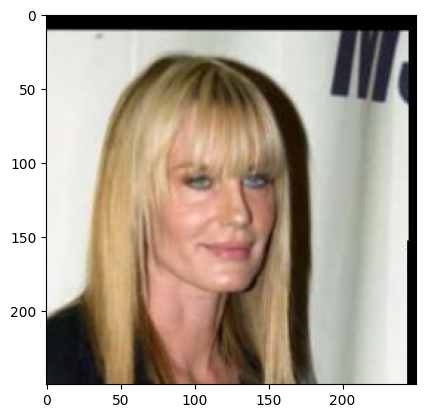

In [267]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

[250, 250, 3]
250 represents the first input dimension / Size x of the image
250 represents the second input dimension / Size y of the image
3 represents the RGB dimension / color channel.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [268]:
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # Input (# of color channels), Output, Kernal Size (How big the Conv is)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 2, stride=2, padding=1),  
            nn.Tanh()
        )
        
    def encode(self,x):
        return self.encoder(x)
        
    def decode(self,x):
        return self.decoder(x)
       
    def forward(self,x):
        h   = self.encoder(x)
        out = self.decoder(h)
        return out
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [269]:
model = AE().to(device)

In [270]:
for data in dataloader:
    img, y = data
    print(img.shape) # [batch_size, RGB, Dimensions]
    break

torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [271]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[-0.0484,  0.0651, -0.1080],
          [ 0.0559, -0.1766,  0.1567],
          [-0.0269, -0.1142,  0.0182]],

         [[-0.1550,  0.0098, -0.0066],
          [ 0.1503, -0.0651,  0.1696],
          [-0.0696,  0.1363,  0.1564]],

         [[-0.1863, -0.0312,  0.0456],
          [ 0.1611,  0.0891,  0.0451],
          [ 0.1414, -0.0581,  0.1339]]],


        [[[-0.1036, -0.1227, -0.1012],
          [ 0.0126,  0.1325, -0.0561],
          [-0.0381, -0.1720, -0.1404]],

         [[ 0.1284,  0.0497,  0.0078],
          [ 0.1881,  0.1000, -0.0738],
          [ 0.0913,  0.0751, -0.0585]],

         [[-0.0284, -0.1166, -0.1534],
          [-0.0137,  0.0026,  0.0054],
          [-0.1193, -0.0690,  0.1785]]],


        [[[ 0.0055, -0.0214,  0.0975],
          [-0.1490,  0.1555, -0.1830],
          [-0.1178, -0.0895, -0.0749]],

         [[-0.0877, -0.1864,  0.1783],
          [-0.0736, -0.0018, -0.0106],
          [-0.1411,  0.0193,  0.0140]],

         [[-0.1405, -0

In [272]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [273]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [274]:
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # ===================forward=====================
        output = model(img)
        # Resize input tensor to match the output size
        img_resized = F.interpolate(img, size=output.size()[2:], mode='bilinear', align_corners=False)
        loss = loss_function(output, img_resized)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/100], loss:12.1507
epoch [2/100], loss:4.5418
epoch [3/100], loss:4.0960
epoch [4/100], loss:3.7997
epoch [5/100], loss:3.5980
epoch [6/100], loss:3.4448
epoch [7/100], loss:3.3223
epoch [8/100], loss:3.2098
epoch [9/100], loss:3.1246
epoch [10/100], loss:3.0592
epoch [11/100], loss:3.0031
epoch [12/100], loss:2.9487
epoch [13/100], loss:2.8990
epoch [14/100], loss:2.8457
epoch [15/100], loss:2.7721
epoch [16/100], loss:2.7169
epoch [17/100], loss:2.6739
epoch [18/100], loss:2.6334
epoch [19/100], loss:2.6017
epoch [20/100], loss:2.5693
epoch [21/100], loss:2.5468
epoch [22/100], loss:2.5212
epoch [23/100], loss:2.5051
epoch [24/100], loss:2.4842
epoch [25/100], loss:2.4650
epoch [26/100], loss:2.4535
epoch [27/100], loss:2.4366
epoch [28/100], loss:2.4222
epoch [29/100], loss:2.4097
epoch [30/100], loss:2.3961
epoch [31/100], loss:2.3845
epoch [32/100], loss:2.3795
epoch [33/100], loss:2.3626
epoch [34/100], loss:2.3566
epoch [35/100], loss:2.3481
epoch [36/100], loss:2.3433


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


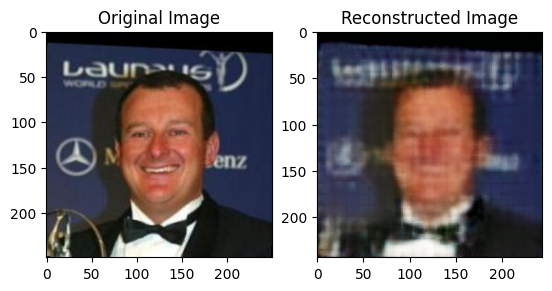

In [289]:
# Got this cell from ChatGPT
def plot_image_pair(x, y):
    # Convert tensors to NumPy arrays
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    # Transpose the dimensions to match the expected format
    x_np = np.transpose(x_np, (1, 2, 0))
    y_np = np.transpose(y_np, (1, 2, 0))

    plt.subplot(121)
    plt.imshow(x_np)
    plt.title('Original Image')

    plt.subplot(122)
    plt.imshow(y_np)
    plt.title('Reconstructed Image')

    plt.show()

for data in dataloader:
    img, y = data
    img = img.to(device)

    # Forward pass through the model
    output = model(img)

    # Visualize the original and reconstructed images
    plot_image_pair(img[0, :, :, :], output[0, :, :, :])
    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?